## Classificação Supervisionada com PyTorch

Este notebook apresenta um fluxo completo de treinamento, validação e teste de um modelo de classificação supervisionada utilizando o framework PyTorch.

O objetivo é demonstrar, passo a passo, o processo de construção de um modelo de rede neural simples, incluindo as etapas de preparação dos dados, normalização, conversão para tensores, treinamento e avaliação do desempenho.

### Etapas do notebook

1. **Carregamento e preparação dos dados**  
   - Seleção das variáveis preditoras e da variável-alvo.  
   - Divisão do conjunto original em treino, validação e teste.  

2. **Padronização das variáveis (normalização)**  
   - Uso do `StandardScaler` para garantir que todas as features possuam média 0 e desvio padrão 1.  

3. **Conversão para tensores do PyTorch**  
   - Transformação dos arrays NumPy em tensores (`float32` para features e `long` para rótulos).  

4. **Definição do modelo e funções auxiliares**  
   - Implementação de um modelo de regressão logística com o PyTorch (`nn.Module`).  
   - Criação de funções para cálculo de perda, acurácia e agregação de métricas.  

5. **Treinamento e validação do modelo**  
   - Uso da função `fit()` para executar múltiplas épocas de aprendizado.  
   - Registro das métricas de desempenho ao longo do treinamento.  

6. **Visualização das curvas de aprendizado**  
   - Plotagem das curvas de perda (treino e validação) e da acurácia de validação.  

7. **Avaliação final e matriz de confusão**  
   - Avaliação do modelo no conjunto de teste.  
   - Visualização da matriz de confusão para análise detalhada dos erros de classificação.

---

Este experimento serve como uma introdução prática aos conceitos fundamentais de aprendizado supervisionado com redes neurais, fornecendo uma base para o desenvolvimento de modelos mais complexos no PyTorch.


In [1]:
%matplotlib inline

# join one or more path components intelligently
from os.path import join

#torch import
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Interface com o sistema operacional
import os

# Manipulação de dataframes
import pandas as pd

# Manipulação de dados tabulares
import numpy as np

# Normalização das características
from sklearn.preprocessing import StandardScaler

# visualização de dados baseada no matplotlib
import seaborn as sns

# Esboço de gráficos
from matplotlib import pyplot as plt

# Classificação de clientes

## Carga e inspeção dos dados

In [2]:
# Definição dos nomes das variáveis (conforme a tabela contida no enunciado)
colnames = ['ESCT', 'NDEP', 'RENDA', 'TIPOR', 'VBEM', 'NPARC',
            'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA', 'CLASSE']

In [3]:
# Leitura dos dados de treino
arquivo = '../../../data/credtrain.txt'
data_train = pd.read_csv(arquivo, sep='\t', header=None, names = colnames)

# Leitura dos dados de teste
arquivo = '../../../data/credtest.txt'
data_test = pd.read_csv(arquivo, sep='\t', header=None, names = colnames)

**Inspeção dos dados**

In [4]:
# Inspeção da dimensão do dataset
print(data_train.shape, data_test.shape)

(1500, 12) (577, 12)


In [5]:
# Inspeção das primeiras linhas do conjunto de treinamento
data_train.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [6]:
# Inspeção das primeiras linhas do conjunto de teste
data_test.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,0,2,500,1,618,10,85,0,36,6,0,0
1,1,0,813,0,552,4,119,0,43,48,119,1
2,3,0,350,0,488,12,66,0,43,0,0,1
3,1,0,1530,0,381,1,398,0,28,48,0,1
4,0,0,688,1,396,10,60,0,49,72,0,1


## Pré-processamento dos dados

### Tratamento da variável ordinal `ESCT` (Estado Civil)

A variável `ESCT` (Estado Civil) assume valores **numéricos (1, 2, 3, 4)**, mas **não representa uma quantidade mensurável**.  
Esses números indicam **categorias ordinais** — ou seja, há uma **ordem lógica** entre os valores (por exemplo, solteiro < casado < divorciado < viúvo), porém as **distâncias entre eles não têm significado numérico**.

Em modelos de aprendizado de máquina, especialmente aqueles baseados em distâncias (como *k*-NN) ou relações lineares (como regressão logística), interpretar diretamente esses números como se fossem quantitativos pode introduzir **viés** e **interpretações incorretas**.  

Para lidar adequadamente com essa variável, há duas abordagens principais:

1. **Codificação ordinal explícita**  
   Mantém os valores 1, 2, 3, 4, desde que a ordem tenha um significado real (por exemplo, nível de escolaridade).  
   Essa abordagem é apropriada quando a progressão entre categorias é interpretável.

2. **Codificação *dummy* (ou *one-hot encoding*)**  
   Transforma `ESCT` em **variáveis binárias** — uma para cada categoria — de forma que:
   - Cada variável assume valor **1** se o registro pertence àquela categoria, e **0** caso contrário.  
   - Se houver 4 categorias, serão geradas **4 variáveis binárias** (`ESCT_1`, `ESCT_2`, `ESCT_3`, `ESCT_4`).

   No entanto, em modelos lineares é recomendável utilizar apenas **\( n - 1 \)** variáveis *dummy* (neste caso, **3**) para evitar **multicolinearidade perfeita**, conhecida como *dummy variable trap*.  
   A categoria omitida atua como **referência** para as demais.

Em resumo:
- Embora `ESCT` contenha números, eles representam **categorias ordinais**, não valores contínuos.  
- A escolha entre **codificação ordinal** e **codificação *dummy*** depende do tipo de modelo e da natureza da variável.  
- Em modelos lineares, **utilizar \( n - 1 \)** dummies é uma prática essencial para evitar redundâncias estatísticas.

In [7]:
# Aplicação no conjunto de treinamento
data_train_new = pd.get_dummies(data = data_train, 
                                prefix='ESCT', 
                                columns=['ESCT'], 
                                drop_first=True)

"""
pd.get_dummies: Convert categorical variable into dummy/indicator variables.
"""

# Inspeção das primeiras linhas
data_train_new.head()

,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE,ESCT_1,ESCT_2,ESCT_3
0,0,360,0,313,9,52,0,25,48,0,1,True,False,False
1,0,350,1,468,10,65,0,33,6,0,1,False,False,False
2,0,1100,0,829,9,125,0,56,48,0,1,False,False,False
3,0,3000,0,552,12,76,1,31,60,0,1,False,False,False
4,0,1000,0,809,12,111,0,24,7,0,1,True,False,False


In [8]:
# Aplicação da transformação sobre o conjunto de teste
data_test_new = pd.get_dummies(data = data_test, prefix='ESCT', columns=['ESCT'], drop_first=True)

"""
pd.get_dummies: Convert categorical variable into dummy/indicator variables
"""

# Inspeção das primeiras linhas
data_test_new.head()

,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE,ESCT_1,ESCT_2,ESCT_3
0,2,500,1,618,10,85,0,36,6,0,0,False,False,False
1,0,813,0,552,4,119,0,43,48,119,1,True,False,False
2,0,350,0,488,12,66,0,43,0,0,1,False,False,True
3,0,1530,0,381,1,398,0,28,48,0,1,True,False,False
4,0,688,1,396,10,60,0,49,72,0,1,False,False,False


**Separação do conjunto de dados em rótulo ($\mathrm{y}$) e features ($\mathrm{x}$)**

O rótulo ($\mathrm{y}$) corresponde ao vetor contendo a variável alvo (CLASSE), enquanto que features ($\mathrm{x}$) corresponde à matriz de dados.

In [9]:
# Transformação da variável alvo do conjunto de treinamento em vetor
y_train = np.array(data_train_new['CLASSE'])

# Inspeção das primeira linhas
y_train[:5]

array([1, 1, 1, 1, 1])

In [10]:
# Transformação da variável alvo do conjunto de teste em vetor
y_test = np.array(data_test_new['CLASSE'])

# Inspeção das primeiras linhas
y_test[:5]

array([0, 1, 1, 1, 1])

### Divisão do conjunto de dados em treino e validação

Nesta etapa, realizamos a separação do conjunto de dados original em duas partes: 
- treinamento (80%)
- validação (20%)

Esse procedimento é essencial para avaliar o desempenho do modelo em dados não vistos durante o processo de aprendizado, ajudando a identificar possíveis problemas de overfitting.

Os passos executados são:

1. **Seleção das variáveis preditoras e da variável-alvo:**
   - As colunas de `data_train_new` são listadas.
   - A coluna `'CLASSE'`, que representa a variável-alvo (rótulo ou classe), é removida da lista de features.
   - Em seguida, as features e os rótulos são convertidos em matrizes NumPy (`X` e `y`) para facilitar o uso em modelos de aprendizado de máquina.

2. **Divisão dos dados com `train_test_split`:**
   - Utiliza-se o método `train_test_split` da biblioteca **scikit-learn** para dividir os dados:
     ```python
     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
     ```
   - **`test_size=0.2`** → reserva 20% dos dados para validação.  
   - **`random_state=42`** → garante reprodutibilidade da divisão.  
   - **`stratify=y`** → mantém a mesma proporção de classes em ambos os conjuntos (boa prática para dados desbalanceados).

3. **Verificação das dimensões:**
   - O comando `print()` exibe as formas (`shape`) das matrizes resultantes para confirmar a correta divisão entre treino e validação.

Ao final, temos:
- `X_train`, `y_train` → usados para ajustar (treinar) o modelo.  
- `X_val`, `y_val` → usados para avaliar o desempenho em dados não vistos durante o treino.

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

# --- Seleção das features ---
features_name_train = list(data_train_new.columns)
features_name_train.remove('CLASSE')  # remove variável alvo

# --- Construção das matrizes de features e rótulos ---
X = np.array(data_train_new.loc[:, features_name_train])
y = np.array(data_train_new['CLASSE'])

# --- Divisão: 80% treino, 20% validação ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,      # 20% para validação
    random_state=42,    # para reprodutibilidade
    stratify=y          # mantém proporções de classes (boa prática)
)

# --- Inspeção ---
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

X_train: (1200, 13)
X_val: (300, 13)
y_train: (1200,)
y_val: (300,)


In [12]:
# Transformação do conjunto de teste remanescente em matriz de dados
features_name_test = list(data_test_new.columns)               # Recuperação dos nomes das colunas
features_name_test.remove('CLASSE')                            # Remoção da variável "CLASSE"
X_test = np.array(data_test_new.loc[:, features_name_test])   # Transformação em matriz

# Inspeção da matriz resultante
X_test

array([[2, 500, 1, ..., False, False, False],
       [0, 813, 0, ..., True, False, False],
       [0, 350, 0, ..., False, False, True],
       ...,
       [3, 1200, 0, ..., False, False, False],
       [0, 600, 0, ..., True, False, False],
       [0, 800, 1, ..., False, False, False]], dtype=object)

### Padronização das variáveis preditoras (features)

Nesta etapa, aplicamos a **padronização** (*standardization*) das variáveis de entrada usando o `StandardScaler` da biblioteca **scikit-learn**.  

A padronização é uma técnica de pré-processamento que transforma cada feature para ter:
- **média igual a 0**
- **desvio padrão igual a 1**

Isso é importante para garantir que todas as variáveis contribuam de forma equilibrada durante o treinamento da rede neural, evitando que atributos com escalas maiores dominem o processo de otimização.

As etapas são as seguintes:

1. **Criação do objeto `StandardScaler`:**  
   ```python
   scaler = StandardScaler()
   ```

Esse objeto armazenará os parâmetros de normalização (médias e desvios padrão).

2. **Ajuste e transformação do conjunto de treino:**

   ```python
   X_train_norm = scaler.fit_transform(X_train)
   ```

   O método `fit_transform()` calcula as estatísticas (média e desvio padrão) **com base apenas no conjunto de treino** e aplica a padronização.

3. **Transformação dos conjuntos de validação e teste:**

   ```python
   X_val_norm = scaler.transform(X_val)
   X_test_norm = scaler.transform(X_test)
   ```

   Aqui utilizamos **os mesmos parâmetros** calculados no treino, garantindo consistência entre os conjuntos.

4. **Verificação das dimensões:**
   O comando final imprime as dimensões das matrizes resultantes para confirmar que o número de amostras e features foi preservado após a padronização.

Essa prática evita *data leakage* (vazamento de informação) e assegura que o modelo aprenda apenas a partir das estatísticas do conjunto de treino.

In [13]:
# Criação do objeto para a padronização das features
scaler = StandardScaler()

# Ajustamento do StandardScaler ao conjunto de dados de treino e padronização dos dados de treino
X_train_norm = scaler.fit_transform(X_train)

# Transformação dos dados de validação e teste com os parâmetros ajustados a partir dos dados de treino
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

# Dimensões dos datasets
print(X_train_norm.shape, X_test_norm.shape, y_train.shape, y_test.shape)

(1200, 13) (577, 13) (1200,) (577,)


## Treinamento do modelo

No trecho de código a seguir, foi realizada uma transformação dos dados em vetores para tensores.
Esses dados ficaram armazenados nas variáveis x_train, y_train, x_test, y_test.

Essa transformação foi feita porque posteriormente iremos utilizá-las como parâmetro para o dataloader.

### Conversão dos conjuntos de dados em tensores do PyTorch

Nesta etapa, convertemos as matrizes NumPy normalizadas (`X_train_norm`, `X_val_norm`, `X_test_norm`) e os vetores de rótulos (`y_train`, `y_val`, `y_test`) em tensores do PyTorch.  

- As **features** (`x_train`, `x_val`, `x_test`) são convertidas para o tipo `float32`, pois as operações da rede neural são realizadas com valores contínuos.
- Os **rótulos** (`y_train`, `y_val`, `y_test`) são convertidos para o tipo `long` (inteiros de 64 bits), pois a função de perda `F.cross_entropy` exige que as classes sejam representadas por índices inteiros.
- Em seguida, imprimimos os *shapes* dos tensores para verificar se o número de amostras e as dimensões estão consistentes entre `x` e `y` em cada subconjunto (treinamento, validação e teste).

Essa conversão é essencial antes de criarmos os objetos `TensorDataset` e `DataLoader`, que serão usados nas fases de treinamento e avaliação do modelo.


In [14]:
# Conversão de features normalizadas
x_train = torch.from_numpy(X_train_norm).float()
x_val = torch.from_numpy(X_val_norm).float()
x_test = torch.from_numpy(X_test_norm).float()

# Conversão de rótulos (labels)
y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()
y_test = torch.from_numpy(y_test).long()

print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

print(f"Train set: {x_train.shape}, classes: {torch.unique(y_train)}")
print(f"Val set:   {x_val.shape}, classes: {torch.unique(y_val)}")
print(f"Test set:  {x_test.shape}, classes: {torch.unique(y_test)}")

torch.Size([1200, 13])
torch.Size([1200])
torch.Size([300, 13])
torch.Size([300])
torch.Size([577, 13])
torch.Size([577])
Train set: torch.Size([1200, 13]), classes: tensor([0, 1])
Val set:   torch.Size([300, 13]), classes: tensor([0, 1])
Test set:  torch.Size([577, 13]), classes: tensor([0, 1])


### Criação dos conjuntos de dados (`TensorDataset`)

Após a conversão das matrizes NumPy em tensores do PyTorch (`x_train`, `y_train`, `x_val`, `y_val`), o próximo passo é organizá-los em objetos do tipo **`TensorDataset`**.

O `TensorDataset` é uma estrutura da biblioteca **`torch.utils.data`** que permite **agrupar tensores correspondentes** — normalmente, as **features** (`x`) e os **rótulos** (`y`) — em um único objeto de dados.  
Cada posição `i` do dataset contém um **par (xᵢ, yᵢ)**, facilitando a iteração durante o treinamento e a validação do modelo.

No código abaixo:
```python
from torch.utils.data.dataset import TensorDataset

train_ds = TensorDataset(x_train, y_train)
val_ds   = TensorDataset(x_val, y_val)
```

- train_ds armazena os dados do conjunto de treinamento;

- val_ds armazena os dados do conjunto de validação.

Esses objetos serão posteriormente utilizados pelos DataLoaders, que gerenciam a leitura dos dados em batches e a aleatorização (embaralhamento) durante o processo de aprendizado.

Em resumo:

- TensorDataset cria um dataset emparelhado a partir de tensores correspondentes.

- Cada elemento do dataset contém (amostra, rótulo).

- É a estrutura intermediária usada antes da criação dos DataLoaders.

In [15]:
from torch.utils.data.dataset import TensorDataset

train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

Abaixo temos o código necessário para verificar a taxa de acurácia da nossa rede. Esse método será necessário para verificar quão bom foi o processo de aprendizado da rede. Ele será invocado a partir do método `fit`, que será implementado mais a frente.

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Criação dos *DataLoaders* para treino e validação

Após a criação dos conjuntos `TensorDataset` (`train_ds` e `val_ds`), o próximo passo é utilizar o objeto **`DataLoader`** do PyTorch para facilitar o processo de treinamento do modelo.

O **`DataLoader`** é responsável por:
- Dividir os dados em **lotes (*batches*)** de tamanho definido;
- **Embaralhar** (shuffle) os exemplos a cada época, evitando que o modelo aprenda uma ordem fixa;
- Permitir o **acesso iterativo** aos dados, otimizando o uso de memória e processamento.

No código abaixo:

```python
batch_size = 40
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size)
```

- batch_size = 40 define que cada lote conterá 40 amostras.
Isso significa que, em cada passo de treinamento, o modelo verá 40 exemplos antes de atualizar seus pesos.
O uso de mini-batches é uma prática comum que equilibra desempenho computacional e estabilidade do gradiente.

- train_loader é criado com shuffle=True, o que embaralha os dados do conjunto de treino a cada época — uma boa prática para evitar padrões indesejados na sequência dos exemplos.

- val_loader é criado sem embaralhamento, pois na validação não há aprendizado nem atualização de pesos, e manter a ordem não afeta o resultado.

Em resumo:

- DataLoader organiza e fornece os dados em lotes.

- shuffle=True é usado apenas no treinamento.

- Essa estrutura permite que o loop de treinamento (for batch in train_loader) acesse os dados de forma eficiente e controlada.

In [17]:
batch_size = 40
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

### Definição do modelo de Regressão Logística com PyTorch

Agora definimos a classe `LogisticModel`, que implementa um modelo de **regressão logística** utilizando o módulo `nn.Module` do PyTorch.  
Esse modelo é o equivalente a uma **camada linear seguida de uma função de ativação *softmax*** (implícita dentro da função de perda `cross_entropy`).

Abaixo temos a implementação da classe `LogisticModel`, que estende a classe `Module` do pacote `nn`. Essa classe carrega a lógica de treinamento e avaliação da rede, e apresenta uma lista de métodos:

- `training_step`: realiza as predições e calcula as perdas durante a fase de treinamento.

- `validation_step`: realiza as predições, calcula as perdas e verifica a taxa de acurácia durante a fase de avaliação.

- `validation_epoch_end`: retornar as perdas e as acurácias.

- `epoch_end`: imprime as perdas e acurácias obtidas ao fim de uma época de treinamento.

In [18]:
class LogisticModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes).float()
        
    def forward(self, xb):
        return self.linear(xb)
    
    def compute_loss(self, batch):
        """Compute training loss for one batch"""
        features, targets = batch
        outputs = self(features)
        targets = targets.long()
        return F.cross_entropy(outputs, targets)
    
    def evaluate_batch(self, batch):
        """Compute validation loss and accuracy for one batch"""
        features, targets = batch
        outputs = self(features)
        targets = targets.long()
        loss = F.cross_entropy(outputs, targets)
        acc = accuracy(outputs, targets)
        return {'val_loss': loss, 'val_acc': acc}
    
    def aggregate_metrics(self, results):
        """Aggregate validation metrics across batches"""
        losses = torch.stack([r['val_loss'] for r in results]).mean()
        accs = torch.stack([r['val_acc'] for r in results]).mean()
        return {'val_loss': losses.item(), 'val_acc': accs.item()}
    
    def log_epoch_results(self, epoch, metrics):
        """Display epoch-level results"""
        print(f"Epoch [{epoch}], val_loss: {metrics['val_loss']:.4f}, val_acc: {metrics['val_acc']:.4f}")


In [19]:
input_size = 13
num_classes = 2
model = LogisticModel(input_size, num_classes)
print(model.parameters)

<bound method Module.parameters of LogisticModel(
  (linear): Linear(in_features=13, out_features=2, bias=True)
)>


A função `fit` registra o custo medido sobre o conjunto de validação e a métrica de cada época. Ele retorna um histórico do treinamento, útil para depuração e visualização. Nesse método passamos configurações iniciais como taxa de aprendizado, tamanho de lote e etc. Essas configurações são denominadas hiperparâmetros. Esses hiperparâmetros possuem uma relevância muito grande no contexto de aprendizado de máquina. Dentro deste método fit, há ainda o método `evaluate`, responsável por avaliar a rede neural durante a fase de validação.

In [20]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train and validate the model for a given number of epochs."""
    optimizer = opt_func(model.parameters(), lr)
    history = []  # Store epoch-wise metrics (train_loss, val_loss, val_acc)
    
    for epoch in range(epochs):
        # ---- Training phase ----
        model.train()
        train_losses = []
        
        for batch in train_loader:
            loss = model.compute_loss(batch)
            train_losses.append(loss.detach())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        mean_train_loss = torch.stack(train_losses).mean().item()
        
        # ---- Validation phase ----
        model.eval()
        val_results = []
        
        with torch.no_grad():
            for batch in val_loader:
                batch_result = model.evaluate_batch(batch)
                val_results.append(batch_result)
        
        result = model.aggregate_metrics(val_results)
        result['train_loss'] = mean_train_loss
        
        model.log_epoch_results(epoch, result)
        history.append(result)
    
    return history


In [21]:
history = fit(300, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8942, val_acc: 0.3969
Epoch [1], val_loss: 0.8802, val_acc: 0.4062
Epoch [2], val_loss: 0.8666, val_acc: 0.4187
Epoch [3], val_loss: 0.8534, val_acc: 0.4344
Epoch [4], val_loss: 0.8405, val_acc: 0.4406
Epoch [5], val_loss: 0.8280, val_acc: 0.4531
Epoch [6], val_loss: 0.8158, val_acc: 0.4656
Epoch [7], val_loss: 0.8040, val_acc: 0.4844
Epoch [8], val_loss: 0.7925, val_acc: 0.4969
Epoch [9], val_loss: 0.7813, val_acc: 0.5094
Epoch [10], val_loss: 0.7705, val_acc: 0.5281
Epoch [11], val_loss: 0.7599, val_acc: 0.5344
Epoch [12], val_loss: 0.7497, val_acc: 0.5437
Epoch [13], val_loss: 0.7397, val_acc: 0.5531
Epoch [14], val_loss: 0.7301, val_acc: 0.5562
Epoch [15], val_loss: 0.7207, val_acc: 0.5688
Epoch [16], val_loss: 0.7116, val_acc: 0.5750
Epoch [17], val_loss: 0.7028, val_acc: 0.5844
Epoch [18], val_loss: 0.6942, val_acc: 0.6031
Epoch [19], val_loss: 0.6859, val_acc: 0.6156
Epoch [20], val_loss: 0.6778, val_acc: 0.6406
Epoch [21], val_loss: 0.6700, val_acc: 0.650

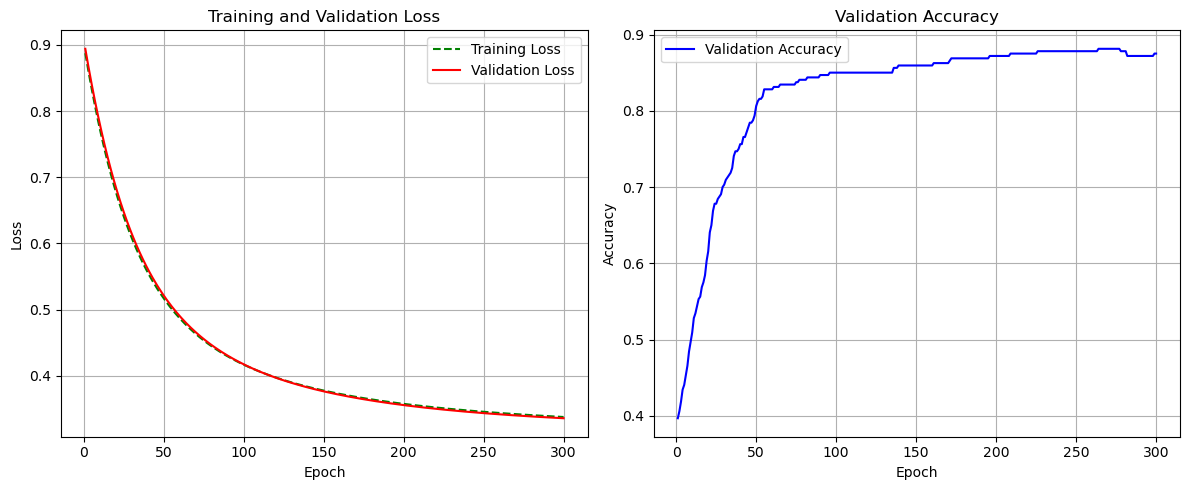

In [22]:
import matplotlib.pyplot as plt

# --- Extração das métricas ---
epochs       = range(1, len(history) + 1)
train_losses = [x['train_loss'] for x in history]
val_losses   = [x['val_loss'] for x in history]
val_accs     = [x['val_acc'] for x in history]

# --- Visualização ---
plt.figure(figsize=(12, 5))

# vas de perda (treino e validação)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'g--', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Curva de acurácia (validação)
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accs, 'b-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Validação do modelo

In [23]:
def evaluate(model, data_loader): 
    results = [] 
    for batch in data_loader: 
        batch_result = model.evaluate_batch(batch) 
        results.append(batch_result)
    return model.aggregate_metrics(results)

{'val_loss': 0.3496675491333008, 'val_acc': 0.8854901790618896}


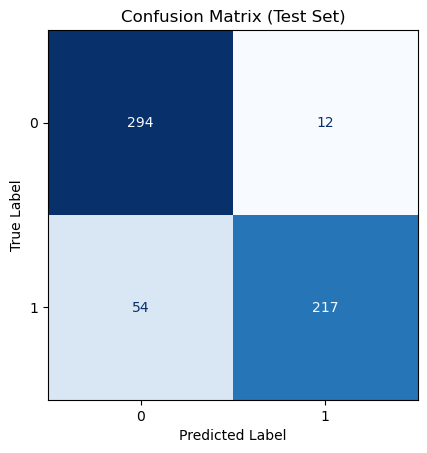

In [24]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Avaliação no conjunto de teste ---
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=40)

result = evaluate(model, test_loader)
print(result)

# --- Geração de previsões ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        _, preds = torch.max(outputs, dim=1)  # obtém classe com maior probabilidade
        all_preds.append(preds)
        all_labels.append(yb)

# --- Consolidação dos resultados ---
all_preds = torch.cat(all_preds).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

# --- Matriz de confusão ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', colorbar=False)

plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.show()


# Modelo para comparação

Acurácia (validação) - LogisticRegression: 0.8856


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1254: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


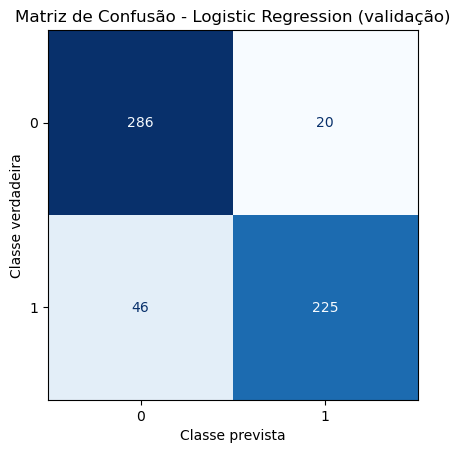

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Treinamento do modelo de regressão logística (scikit-learn) ---
logreg = LogisticRegression(
    multi_class='multinomial',  # usa softmax (equivalente ao modelo PyTorch)
    solver='lbfgs',             # método robusto para problemas multiclasse
    max_iter=1000,              # aumenta o limite de iterações (por segurança)
    random_state=42
)

logreg.fit(X_train_norm, y_train)

# --- Avaliação no conjunto de validação ---
y_val_pred = logreg.predict(X_test_norm)
val_acc = accuracy_score(y_test, y_val_pred)

print(f"Acurácia (validação) - LogisticRegression: {val_acc:.4f}")

# --- Matriz de confusão ---
cm = confusion_matrix(y_test, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', colorbar=False)
plt.title('Matriz de Confusão - Logistic Regression (validação)')
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.show()


# Seção de Exercícios – Modelo Linear com PyTorch

Nesta seção, você realizará experimentos práticos com o modelo `LogisticModel`, implementado em PyTorch, para compreender melhor como funciona uma *rede neural linear* (regressão logística multiclasse).

Os exercícios a seguir visam:
- Consolidar o entendimento do processo de treinamento e validação;
- Investigar o impacto dos hiperparâmetros;
- Explorar métricas e visualizações para análise de desempenho.

---

## Exercício 1 — Análise das curvas de treinamento
1. Treine novamente o modelo `LogisticModel` com diferentes números de épocas (`epochs = 50`, `150`, `300`).  
2. Plote as curvas de **perda de treino (`train_loss`)** e **perda de validação (`val_loss`)** em função da época.  
3. Analise:
   - O modelo converge rapidamente?  
   - Há indícios de **overfitting** (val_loss sobe enquanto train_loss desce)?  
   - O modelo está **subajustado** (underfitting)?

Escreva suas conclusões ao final da célula.

---

## Exercício 2 — Acurácia e matriz de confusão
1. Após o treinamento, avalie o modelo no conjunto de **teste**.  
2. Gere e visualize a matriz de confusão.  
3. Responda:
   - Em quais classes o modelo mais erra?  
   - Há confusão sistemática entre categorias específicas?  
   - As classes estão desbalanceadas?

Comente brevemente suas observações.

---

## Exercício 3 — Efeito da taxa de aprendizado
1. Treine o modelo com diferentes valores de **taxa de aprendizado** (`lr`):  
   \[
   lr = [0.1, 0.01, 0.001]
   \]
2. Observe o comportamento das curvas de perda.  
3. Explique:
   - Taxas maiores geram oscilações ou instabilidade?  
   - Taxas menores resultam em convergência mais lenta?

---

## Exercício 4 — Impacto do tamanho do *batch*
1. Repita o treinamento com tamanhos de *batch* diferentes:  
   \[
   batch\_size = [10, 40, 100]
   \]
2. Observe se o valor da perda flutua mais ou menos entre épocas.  
3. Explique como o tamanho do *batch* afeta:
   - A estabilidade do gradiente;  
   - O tempo de convergência.

---

## Exercício 5 — Regularização (opcional)
1. Adicione o parâmetro de regularização L2 (*weight decay*) no otimizador:
   ```python
   optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)
